## Orphan molecule formation due to poor alignment

Orphan molecules can form by poor alignment, e.g. if a shearing product is marginally mappable. In that case, most reads arising from that molecule will remain unmapped or multi-mapped, and only a few (by chance) become uniquely mappable.

We explore this hypothesis in this notebook.

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import editdistance
import pandas as pd
import itertools
import operator
from bisect import bisect_left, bisect_right
from commons import *

leven = editdistance.bycython.eval

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [2]:
# select dataset
mol_h5_path = '/Users/mehrtash/Data/10x/pbmc4k_molecule_info.h5'
genes_tsv_path = None

In [3]:
mol_info = MoleculeInfo(mol_h5_path, genes_tsv_path)

In [4]:
# select a range of barcodes
min_umi_count = 1000
max_umi_count = 50000
test_barcode_set = {barcode for barcode, total_umi in mol_info.total_umi_per_barcode.items()
                    if min_umi_count <= total_umi <= max_umi_count}
print(f'Selected {len(test_barcode_set)} barcodes in range ({min_umi_count}, {max_umi_count})')

# obtain full UMI count statistics
full_count_stats = get_full_umi_count_statistics(
    test_barcode_set, mol_info.gene_array, mol_info.reads_array, mol_info.barcode_array)

gene_index_sorted_by_expression = get_gene_index_sorted_by_expression(full_count_stats)
gene_index_sorted_by_expression.remove(mol_info.unmappable_gene_idx)

Selected 4481 barcodes in range (1000, 50000)


## Exploration

In [138]:
# molecules to study
included_gene_indices = [32549, 32551, 23869, 23870, 23863, 23865]
gene_cond = np.zeros((len(mol_info.barcode_array),)).astype(bool)
for gene_index in included_gene_indices:
    gene_cond = gene_cond | (mol_info.gene_array == gene_index)

In [43]:
cond = (mol_info.reads_array == 1) #& gene_cond
indices = np.where(cond)[0]

max_mols = 10_000_000
max_mols = min(max_mols, len(indices))

unmapped_frac_list = []
nc_mapped_frac_list = []

for mol_index in indices[:max_mols]:
    barcode, umi = mol_info.barcode_array[mol_index], mol_info.umi_array[mol_index]
    
    # index of all other molecules with the same barcode and umi
    all_mols = get_molecules(barcode, umi, mol_info)
    
    cm, cmup, um, ncm = 0, 0, 0, 0
    for other_index in all_mols:
        cm += mol_info.reads_array[other_index]
        ncm += mol_info.nonconf_mapped_reads_array[other_index]
        cmup += mol_info.conf_mapped_uniq_read_pos_array[other_index]
        um += mol_info.unmapped_reads_array[other_index]

    total_reads = cm + um + ncm
    unmapped_frac = um / total_reads
    nc_mapped_frac = ncm / total_reads
    unmapped_frac_list.append(unmapped_frac)
    nc_mapped_frac_list.append(nc_mapped_frac)

In [44]:
label = 'orphan'
color = 'orange'

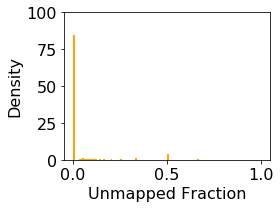

In [45]:
fig = plt.figure(figsize=(4, 3))
_ = plt.hist(unmapped_frac_list, bins=100, range=(0, 1), density=True, color=color)
ax = plt.gca()
ax.set_xlabel('Unmapped Fraction', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_ylim((0, 100))
plt.tight_layout()
plt.savefig(f'./plots/pbmc4k_unmapped_reads_{label}_mols.pdf')

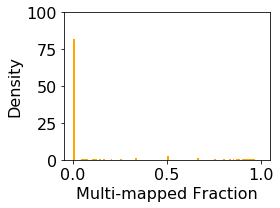

In [46]:
fig = plt.figure(figsize=(4, 3))
_ = plt.hist(nc_mapped_frac_list, bins=100, range=(0, 1), density=True, color=color)
ax = plt.gca()
ax.set_xlabel('Multi-mapped Fraction', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_ylim((0, 100))
plt.tight_layout()
plt.savefig(f'./plots/pbmc4k_multimapped_reads_{label}_mols.pdf')